# Predict the median housing value in CA.

## Import the data

Start by creating a function to import the data.

In [4]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Import the data.

In [5]:
fetch_housing_data()

Create a function to load the data.

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Load the data.

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Look at the structure of the data

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


ocean_proximity can be any Python object, but since it came from a csv we know it's a string.
ocean_proximity looks like it may be categorical.  How many distinct values exist?

total_bedrooms has missing data (20433 vs. 20640 for the other attributes.

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Look at the numerical fields.

In [9]:
housing.describe() # Null values are ignored.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot a histogram to visualize the data.

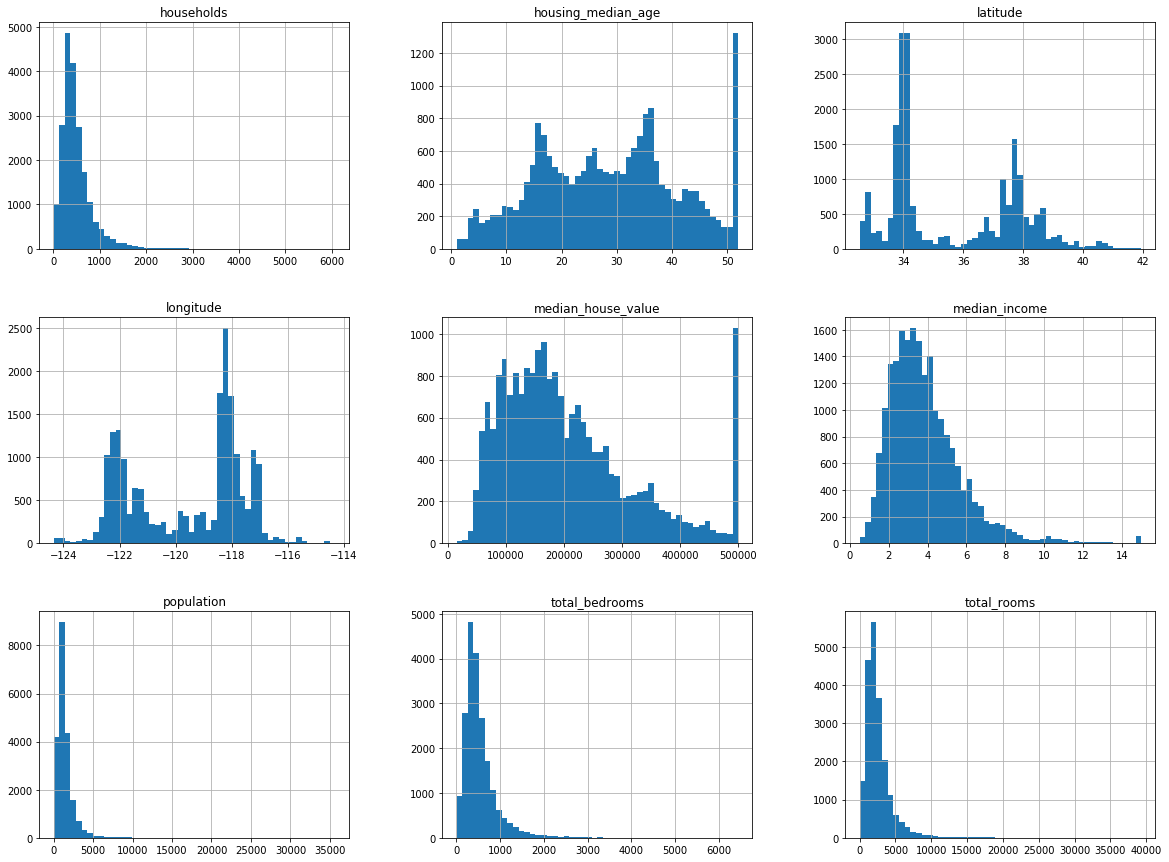

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Some observations:
* Median income is not in USD
* Median age and median value was capped (client team told us this after we noticed median income was not in USD)
 * Median value being capped can be a serious issue because that's what we're predicting
* All of the attributes have different scales
 * May need to employ feature scaling
* Many of the histograms are tail heavy
 * We may want to transform those data, e.g. by computing their logarithm (pg. 59)

## Create a test set

Want 20% for testing and 80% for training.  One way to do this would be to divide the data randomly.

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # What is "data" type, what does iloc do?

In [11]:
train_set, test_set = split_train_test(housing, 0.2)

In [12]:
len(train_set)

16512

len(test_set)

One issue with dividing the data randomly is that each time the notebook is run, a different part of the data will be used as the test set.

To overcome this, we could set np.random.seed to some value, thus ensuring np.random.permutation will return the same sequence of numbers.

The concern with just setting np.random.seed to a value is that if the dataset is updated, then data that was originally in the training set will end up in the test set and vice versa.  This is probably not a concern for this exercise, but may be a real world concern.

The author then suggests that creating a hash function over the data indices would eliminate the issues associated with using np.random, provided an new data added to the dataset was appended to the end of the original dataset.

Lastly, the author notes that scikit-learn has a built in method to split data into training and test sets: train_test_split.  Also, if multiple datasets with the same number of rows are passed to this method it will split them all on the same indices.  This is useful if the labels and features are in separate dataframes.

In [56]:
from sklearn.model_selection import train_test_split

# Does train_test_split have the same issue as using random.permutation?
# If the data changed, then how would train_test_split avoid including data that was originally in the test set in
# the new training set?
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [57]:
len(train_set)

16512

In [58]:
len(test_set)

4128

In [59]:
# train_test_split??

__Representative data must be chosen for the test set.  Random sampling can lead to biased data.__  Stratified sampling breaks the population into homogenous subgroups (strata) and then the right number of instances are sampled from each subgroup.

For example, if median income is a very important predictor variable for median housing prices, then creating a category that is representative of various median incomes may be useful.

Why create categories for median income and not use the existing variable data?

In [60]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])



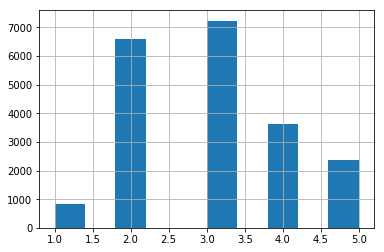

In [61]:
housing["income_cat"].hist() # Don't forget to run %matplotlib inline.
# When plt.show() isn't called, the plot still shows, 
# but there is an additional output above the plot: <matplotlib.axes._subplots.AxesSubplot at 0x24f59a1df60>.
# Apparently, this is normal.
plt.show() 

Now that median income has been split into (arbitrary?) categories, we are able to do stratified sampling of median income.  Scikit-learn has built-in functionality for stratified sampling.

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To see if the test set sample is representative with respect to median income categories first look at the proportion of categories in the full dataset.

In [63]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Then compare that to the proportion of categories in the test set.

In [43]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [44]:
# TODO - Generate figure 2-10 here

In [45]:
# Drop the income_cat attribute to return the dataset back to its original state.

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize the data

We only want to explore the training set.  Don't look at the test set.
If the training set is large, we may only want to explore a sample of it to make things faster.

In [46]:
# Our training set is small enough to explore the entire set.
# Make a copy of the set to avoid altering the original.

housing = strat_train_set.copy()

### Visualizing geographical data

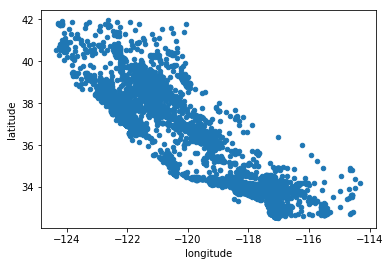

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Set the plot alpha to highlight places with a high density of data points.

What does it mean to be a "place with a high density of data points"?

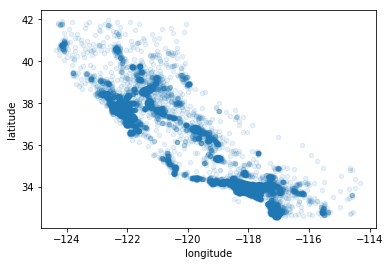

In [57]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

In [65]:
#housing.plot??

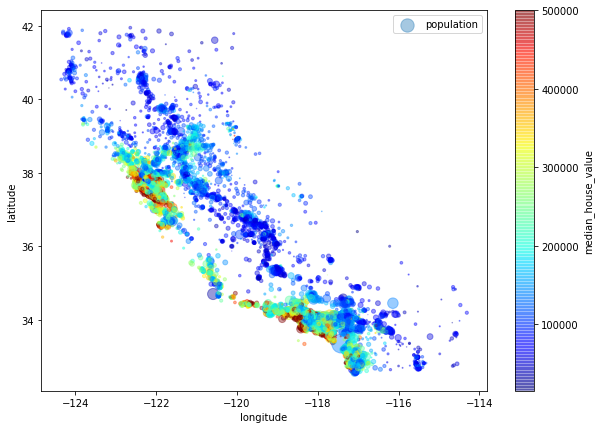

In [78]:
# Below line is needed to make the x-axis labels show due to a bug in Pandas.
# https://github.com/jupyter/notebook/issues/2353
# https://stackoverflow.com/questions/43578976/pandas-missing-x-tick-labels
fig, ax = plt.subplots()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, ax=ax)

plt.legend()
# plt.show() # Seems to be the same as plt.legend(), except without the <matplotlib.legend.Legend at ...> message.

Looks like homes closer to the ocean are more expensive in general.  May be useful to use a clustering algorithm to help find the main clusters and add new features that would represent the centers of those clusters.

### Looking for correlations

Calculate how much each attribute correlates with the median house value using standard correlation coefficient (Pearson's r).

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

__Correlation coefficient only measures linear correlations.  Non-linear correlations may exist (see figure 2-14).__

Also, correlation has nothing to do with the slope.  If one variable increases (linearly?) when another increases, then that is a positive correlation.

However, doesn't it have something to do with slope?  After all, if the correlation isn't linear,
then it doesn't show up as a correlation.  So, it needs a constant slope to show up as a correlation?

In [43]:
from IPython.display import SVG, display

# Figure 2-14
# Found here: https://en.wikipedia.org/wiki/Correlation_and_dependence
display(SVG(url="https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg"))

<IPython.core.display.SVG object>

Another attempt at showing the SVG figure 2-14
![](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg)

Pandas scatter_matrix will plot every attribute against every other attribute.

So, 11 attributes will lead to 11^2 plots.  Instead, we can focus on a few attributes.

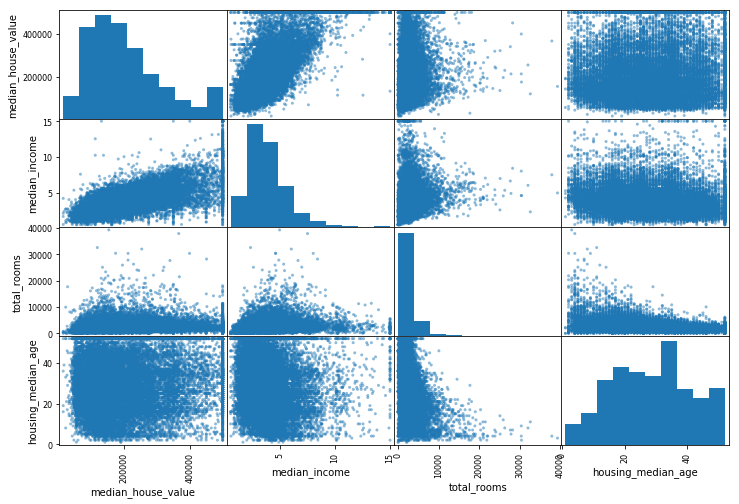

In [39]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show() # Without this the datatype is printed out first followed by the graphs.

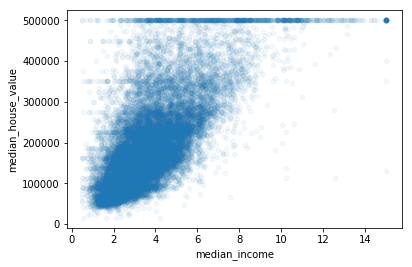

In [49]:
# Most promising predictor of median house value is median income.  Let's see that more closely.

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.05)
plt.show()

The median housing value stays tightly packed as the median income increases indicating a correlation.

There is also the horizontal line at 500,000 becuase of the price cap in the data.
However, there is also horizontal lines at 450,000, 350,000, 280,000.  Why is that?
Consider removing those districts to prevent the model from picking up on this data.

Do we need to try to understand what's causing the lines first?  
Are the horizontal lines 'quirks' that should be avoided, or legitimate data?
Does the answer depend on the model we choose?

## Experimenting with Attribute Combinations

Think about what variables we have and what variables we may want that we can derive from them.

For example, our datasets have total rooms per district, but it would probably be helpful to know rooms per house.

In [76]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [77]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value                   1.000000
median_income                        0.687160
rooms_per_household                  0.146285
total_rooms                          0.135097
housing_median_age                   0.114110
bedrooms_per_household_population    0.065419
households                           0.064506
total_bedrooms                       0.047689
population_per_household            -0.021985
population                          -0.026920
bedrooms_per_household              -0.043343
longitude                           -0.047432
latitude                            -0.142724
bedrooms_per_room                   -0.259984
Name: median_house_value, dtype: float64

This is not meant to be thourough, but instead is meant to be a quick exploration to gain insight.

## Prepare the data for Machine Learning Algorithms

Write functions to prepare the data - don't do it manually for the following reasons:
* Allows transformations to be reproduced on any dataset
* Builds a library of transformations that can be used on future projects
* Can use in the live system on new data before feeding it to your ML algorithms
* Will make it possible to try different transformations to find the ones that work best

In [78]:
# Revert to a clean training dataset, since we've been exploring with the first copy.

# Separate the predictors and targets because we don't want to apply transformations to the target variables.
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

total_bedrooms has missing values.  We can do one of the following to handle this:
* Get rid of the districts with missing data
* Get rid of the attribute on all data sets
* Set the value of the missing values to some value (mean, median, 0, etc.)
 * You will need to compute the value on the training set and use it to fill in missing values there,
 but also save it so that it can fill in missing values on the test set and on new data once the system goes live

In [79]:
# housing.dropna(subset=["total_bedrooms"]) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True) # option 3

In [80]:
# Option 3, fill missing values with their median value.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Median can only be computed for numerical values, so remove make a copy of the data without categorical values.
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [84]:
imputer.statistics_ # Don't know why the results here are scientific notation.

array([-1.185100e+02,  3.426000e+01,  2.900000e+01,  2.119500e+03,
        4.330000e+02,  1.164000e+03,  4.080000e+02,  3.540900e+00,
        5.232284e+00,  2.030314e-01,  2.817653e+00,  1.048780e+00,
        3.726370e-01,  3.000000e+00])

In [86]:
housing_num.median().values

array([-1.185100e+02,  3.426000e+01,  2.900000e+01,  2.119500e+03,
        4.330000e+02,  1.164000e+03,  4.080000e+02,  3.540900e+00,
        5.232284e+00,  2.030314e-01,  2.817653e+00,  1.048780e+00,
        3.726370e-01,  3.000000e+00])

In [87]:
# Fill in the missing values.
X = imputer.transform(housing_num)

In [88]:
# Put the filled in data back into a DataFrame.
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes

In [91]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Convert the categorical ocean_proximity attribute to a number to make it more suitable for the ML algorithm.

In [92]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [94]:
ordinal_encoder.categories_ # Not to be confused with ordinal_encoder.categories.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

There is an issue with representing categorical data as ordinal values: Most ML algorithms will assume values close together are more similar than values farther apart.

So in the above example, the ML algorithm may assume INLAND and NEAR OCEAN are more similar than <1H OCEAN and OCEAN.

To correct this, we are going to use _one-hot encoding_ which creates a matrix that has a single 1 on each row
in a different column representing a category.

One-hot encoding would wastefully use a lot of memory if it were stored in a dense array like a numpy array, because most of the memory would be taken up by zeros.

So, instead of storing the one-hot encoding as a numpy array it is stored as a sparse matrix.

However, if there were a lot of categories, then even this could lead to degraded performance and slowed training.

In that case, we would want to use _embeddings_ instead of one-hot encoding.  However, __embeddings require a good understanding of neural networks, so they won't be covered until chapter 14__.

In [96]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [100]:
housing_cat_1hot.toarray()[:10] # Compare to the ordinal encoder.

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [101]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers